In [1]:
import numpy as np
import tensorflow as tf
import gym, gym.spaces
import logging
import matplotlib.pyplot as plt

In [2]:
logging.basicConfig(level=logging.DEBUG)

In [3]:
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [4]:
# parameters
state_size = 6400
hidden_size = 20
save_dir = './save_dqn/'

In [5]:
# preprocess function
def preprocess(image, first=False):
    """ prepro 210x160x3 uint8 frame into 6400 (or 80x80) nD float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else just set to 1
    if first:
        return np.reshape(image.astype(np.float).ravel(), [1,80,80,3])
    else:
        return np.reshape(image.astype(np.float).ravel(), 6400)

In [18]:
# Deep Q Network setup
class DeepQNetwork:

    def __init__(self, n_actions, n_features, learning_rate=0.01,
            reward_decay=0.99,
            e_greedy=0.95,
            update_params_step=300,
            buffer_size=500,
            batch_size=32,
            output_graph=False,
            hidden_size = 20,
            save_dir = './save_dqn/'):
        
        # set up all parameters
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.replace_target_iter = update_params_step
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.epsilon = e_greedy
        self.save_dir = save_dir

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.buffer_size, n_features * 2 + 2))

        # build two parrellel networks: target_net, evaluate_net
        self._build_net()
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_q_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='eval_q_net')

        with tf.variable_scope('update_all_parameters', reuse=tf.AUTO_REUSE):
            self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # to use tensorboard, type in terminal: tensorboard --logdir=logs
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.loss_his = []
        self.max_q = []

    def _build_net(self):
        """Builds 1) action prediction 2) q-net structures 3) loss calculation and minization structures"""
        ## initialize inputs
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input State
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')  # input Next State
        self.r = tf.placeholder(tf.float32, [None, ], name='r')  # input Reward
        self.a = tf.placeholder(tf.int32, [None, ], name='a')  # input Action

        w_initializer, b_initializer = tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)

        ## build evaluate net for action predictions
        with tf.variable_scope('eval_net', reuse=tf.AUTO_REUSE):
            e1 = tf.layers.dense(self.s, hidden_size, tf.nn.relu, kernel_initializer=w_initializer, name='e1')
            self.q_eval = tf.layers.dense(e1, self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='q')

        ## build target_net for action predictions
        with tf.variable_scope('target_net', reuse=tf.AUTO_REUSE):
            t1 = tf.layers.dense(self.s_, hidden_size, tf.nn.relu, kernel_initializer=w_initializer, name='t1')
            self.q_next = tf.layers.dense(t1, self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='t2')

        # target Q value
        with tf.variable_scope('q_target', reuse=tf.AUTO_REUSE):
            q_target = self.r + self.gamma * tf.reduce_max(self.q_next, axis=1, name='Qmax_s_')    # shape=(None, )
            self.q_target = tf.stop_gradient(q_target)
        # evaluted Q value
        with tf.variable_scope('q_eval', reuse=tf.AUTO_REUSE):
            a_indices = tf.stack([tf.range(tf.shape(self.a)[0], dtype=tf.int32), self.a], axis=1)
            self.q_eval_wrt_a = tf.gather_nd(params=self.q_eval, indices=a_indices)    # shape=(None, )
        # loss function
        with tf.variable_scope('loss', reuse=tf.AUTO_REUSE):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval_wrt_a, name='TD_error'))
        # minimize the difference
        with tf.variable_scope('train', reuse=tf.AUTO_REUSE):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

    def store_transition(self, s, a, r, s_):
        """Add a new experience to memory."""
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % self.buffer_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def choose_action(self, state):
        """Returns actions for given state as per current policy (epsilon greedy).
        Params
        ======
            state (array_like [6400]): current state
        """
        # reshape to the input shape of the tf variable
        state = state[np.newaxis, :]
        if np.random.uniform() < self.epsilon:
            # forward feed the state and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: state})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action


    def learn(self):
        """Update value parameters using given batch of experience tuples & then train the network."""    
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.target_replace_op)
            #logging.info('\nTarget Q-net parameters replaced')

        # sample batch memory when memory is full
        if self.memory_counter > self.buffer_size:
            sample_index = np.random.choice(self.buffer_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        # train the nextwork
        _, loss, q_n = self.sess.run(
            [self._train_op, self.loss, self.q_eval_wrt_a],
            feed_dict={
                self.s: batch_memory[:, :self.n_features],
                self.a: batch_memory[:, self.n_features],
                self.r: batch_memory[:, self.n_features + 1],
                self.s_: batch_memory[:, -self.n_features:],
            })

        # store the loss & q-value for inspection
        self.loss_his.append(loss)
        self.max_q.append(np.max(q_n))

        # tracking training steps (for parameters update & plotting)
        self.learn_step_counter += 1

    def plot_loss(self):
        """Visualize loss in a graph."""
        plt.plot(np.arange(len(self.loss_his)), self.loss_his)
        plt.ylabel('Loss')
        plt.xlabel('Training steps')
        plt.show()
    
    def plot_max_q(self):
        """Visualize max_q in a graph."""
        self.mean_max_q = [x[0]/x[1] for x in list(zip(np.cumsum(self.max_q), range(1,len(self.max_q)+1)))]
        plt.plot(np.arange(len(self.mean_max_q)), self.mean_max_q)
        plt.ylabel('Mean of Max Q Value')
        plt.xlabel('Training steps')
        plt.show()  
        
    def save_model(self):
        self.ckpts_path = self.save_dir + "dqn.ckpt"
        self.saver = tf.train.Saver()
        self.saver.save(self.sess, self.ckpts_path)

In [20]:
# train network over episodes based on the DeepQNet
def run_DQN(episodes):

    # keep track of steps for learning resets
    step = 0

    for episode in range(episodes):

        # initial state
        state = env.reset()

        while True:
            
            # RL choose action based on state
            action = RL.choose_action(preprocess(state))

            # RL take action and get next state and reward
            state_, reward, done, info = env.step(action)

            # RL save observed states to memory
            RL.store_transition(preprocess(state), action, reward, preprocess(state_))
            
            # only learn when there are enough episodes
            if (step > 200) and (step % 5 == 0):
                RL.learn()

            # next state as the current
            state = state_

            # break at end of an episode
            if done:
                if episode % 10 == 0:
                    logging.info('Finsihed episode {}'.format(str(episode)))
                break
            step += 1

    # end of game
    logging.info('Game Over')
    env.close()

In [21]:
# play game over episodes based on the trained DeepQNet
def play(episodes=1000):
    
    saver = tf.train.Saver()
    saver.restore(RL.sess, RL.ckpts_path)

    # keep track of steps for learning resets
    step = 0
    
    rewards = []

    for episode in range(episodes):

        total_reward = 0
        
        # initial state
        state = env.reset()

        while True:
            
            # RL choose action based on state
            action = RL.choose_action(preprocess(state))

            # RL take action and get next state and reward
            state_, reward, done, info = env.step(action)
            
            # Increment reward
            total_reward += reward

            # next state as the current
            state = state_

            # break at end of an episode
            if done:
                rewards.append(total_reward)
                break
            step += 1

    # end of game
    logging.info('Game Over')
    env.close()
    
    """Visualize total rewards in a graph."""
    plt.plot(np.arange(len(rewards)), rewards)
    plt.ylabel('Total Reward')
    plt.xlabel('Episode')
    plt.show()  

/home/u21910/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
INFO:root:Finsihed episode 0
INFO:root:Finsihed episode 10
INFO:root:Finsihed episode 20
INFO:root:Finsihed episode 30
INFO:root:Finsihed episode 40
INFO:root:Finsihed episode 50
INFO:root:Finsihed episode 60
INFO:root:Finsihed episode 70
INFO:root:Finsihed episode 80
INFO:root:Finsihed episode 90
INFO:root:Finsihed episode 100
INFO:root:Finsihed episode 110
INFO:root:Finsihed episode 120
INFO:root:Finsihed episode 130
INFO:root:Finsihed episode 140
INFO:root:Finsihed episode 150
INFO:root:Finsihed episode 160
INFO:root:Finsihed episode 170
INFO:root:Finsihed episode 180
INFO:root:Finsihed episode 190
INFO:root:Finsihed episode 200
INFO:root:Finsihed episode 210
INFO:root:Finsihed episode 220
INFO:root:Finsihed episode 230
INFO:root:Finsihed episode 240
INFO:root:Finsihe

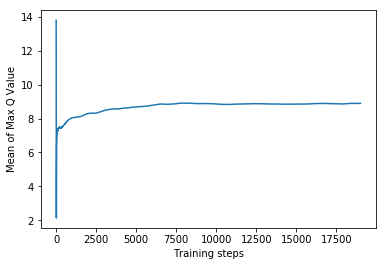

INFO:tensorflow:Restoring parameters from ./save_dqn/dqn.ckpt


INFO:tensorflow:Restoring parameters from ./save_dqn/dqn.ckpt
INFO:root:Game Over
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


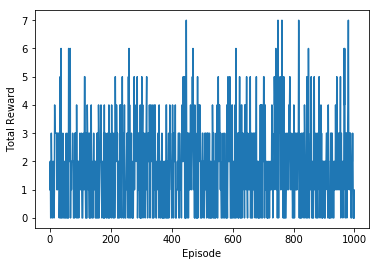

In [22]:
if __name__ == "__main__":

    # breakout game
    env = gym.make("Breakout-v0")

    RL = DeepQNetwork(env.action_space.n, state_size,
                      learning_rate=0.009,
                      reward_decay=0.95,
                      e_greedy=0.9,
                      update_params_step=200,
                      buffer_size=2000,
                      hidden_size=20
                      # output_graph=True
                      )
    
    run_DQN(episodes=300)
    
    RL.plot_max_q()
    RL.save_model()
    
    play(episodes=1000)